In [1]:
from openparticle.hamiltonians import *
from openparticle import ParticleOperator, Fock
from openparticle.utils import get_fock_basis, generate_matrix
import numpy as np
from openparticle.dlcq import *
from itertools import combinations
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"
plt.rc('text', usetex=True)

In [2]:
def get_sign(op):
    return 1 if op.creation else -1

def get_mass(op, m_F, m_B):
    if op.particle_type == 'fermion':
        return m_F
    elif op.particle_type == 'antifermion':
        return m_F
    elif op.particle_type == 'boson':
        return m_B
    
def get_momentum(op):
    if op.particle_type == 'fermion' or op.particle_type == 'antifermion':
        return p(op.mode + 1/2)
    elif op.particle_type == 'boson':
        return p(op.mode + 1)

def renorm_Yukawa_first_order(Lambda, t, m_F = 1, m_B = 1):
    H1 = three_point_yukawa(Lambda)

    ren_H1 = ParticleOperator({})

    for term in H1.to_list():
        exp_factor = 0
        for op in term.split():
            exp_factor += get_sign(op) * get_mass(op, m_F, m_B)**2 * 1/get_momentum(op)
        ren_H1 += np.exp(-exp_factor**2 * t) * term

    return ren_H1

def renorm_Yukawa_second_order(Lambda, t, m_F = 1, m_B = 1):
    H1inst = instantaneous_yukawa(Lambda)

    ren_H1inst = ParticleOperator({})

    for term in H1inst.to_list():
        exp_factor = 0
        for op in term.split():
            exp_factor += get_sign(op) * get_mass(op, m_F, m_B)**2 * 1/get_momentum(op)
        ren_H1inst += np.exp(-exp_factor**2 * t) * term

    return ren_H1inst

In [3]:
def renormalized_Yukawa(Lambda, t):
    return free_boson_Hamiltonian(Lambda) + free_fermion_Hamiltonian(Lambda) + renorm_Yukawa_first_order(Lambda, t) + \
        renorm_Yukawa_second_order(Lambda, t)

In [4]:
def plot_m2_vs_pp(Pplus_val, Lambda, g = 1):

    print("Generating Hamiltonian...")
    ham = yukawa_Hamiltonian(Lambda, g = g)
    print("Hamiltonian generated.")
    evals = []
    pplus_arr = [i for i in range(0, Pplus_val + 1)]


    for pp in pplus_arr:
        print("--- P+: ", pp, "---")
        print("Partitioning... ")
        pp_tmp_basis = Pplus_states_partition(pp)
        print("Generating matrix...")
        tmp_mat = generate_matrix(ham, pp_tmp_basis)
        print("Computing eigenvalues...")
        evals.append(min(np.linalg.eigvalsh(tmp_mat)) * pp)

    # return evals, pplus_arr
    # # return evals, pplus_arr
    plt.figure(figsize=(3,3), dpi = 200)
    plt.scatter(pplus_arr[1:], np.array(evals)[1:], marker='.')
    # plt.yscale('symlog')
    plt.xlabel(f'$\Lambda$')
    plt.ylabel(f'$M^2$')
    plt.tight_layout()
    # plt.savefig('yukawa_spectrum.jpg')
    plt.show()

Generating Hamiltonian...
Hamiltonian generated.
--- P+:  0 ---
Partitioning... 
Generating matrix...
Computing eigenvalues...
--- P+:  1 ---
Partitioning... 
Generating matrix...
Computing eigenvalues...
--- P+:  2 ---
Partitioning... 
Generating matrix...
Computing eigenvalues...
--- P+:  3 ---
Partitioning... 
Generating matrix...
Computing eigenvalues...


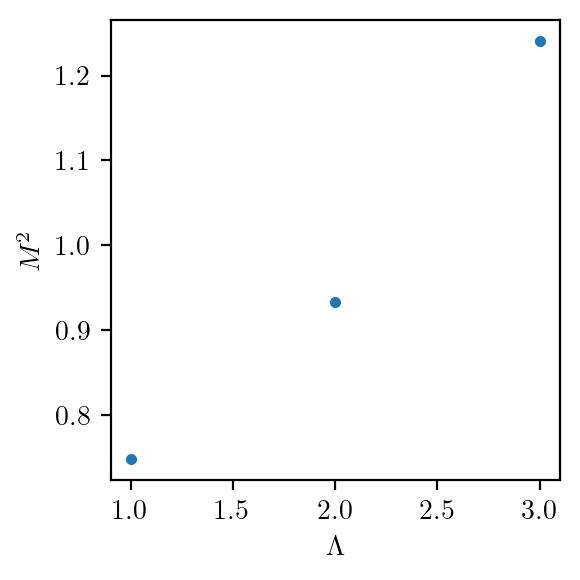

In [5]:
cut = 3
plot_m2_vs_pp(Pplus_val=cut, Lambda=cut, g = 0.5)

### Partition $H$ into blocks of definite $P^+$

Text(0.5, 1.0, '$\\Lambda = 2$')

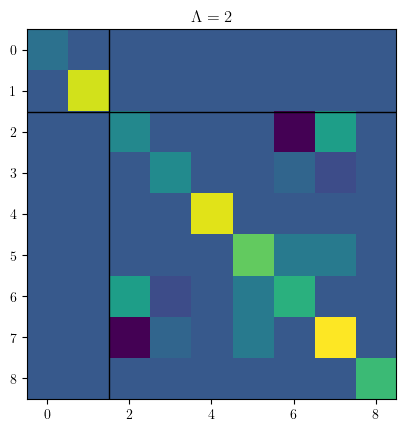

In [6]:
t = 1
pp = 2
basis = [Pplus_states_partition(i)[j] for i in range(1, pp + 1) for j in range(len(Pplus_states_partition(i)))]
plt.imshow(
    np.real(
        generate_matrix(renormalized_Yukawa(pp, t = t), basis)
    )
)
n_states_i = 0
for i in range(1, pp):
    n_states_i += len(Pplus_states_partition(i))
    plt.axvline(x=n_states_i - 0.5, color='black', linewidth=1)
    plt.axhline(y=n_states_i - 0.5, color='black', linewidth=1)

plt.title(f'$\Lambda = {pp}$')

## New $\mathcal{O}(g^2)$ Diagrams

In [2]:
Lambda = 4
L = 1
t = 0.1
m_F = 1
m_B = 1

### Fermion Current $J(x)$

$$
\tilde J(q) = g \int_{-\infty}^\infty \int_{-\infty}^\infty \frac{dq_1^+dq_2^+}{(4\pi)^2}\delta(q + q_1 - q_2):\tilde \psi^\dagger(q_1)\gamma^0 \tilde \psi(q_2):
$$

$$
C_\phi = \int_0^\infty \frac{dq^+}{4\pi|q^+|}:\tilde J(-q) \tilde J(q):
$$

$
C_\phi = g\int_0^\infty \frac{dq^+}{4\pi|q^+|}\int_{-\infty}^\infty\int_{-\infty}^\infty\int_{-\infty}^\infty\int_{-\infty}^\infty \frac{dq_1^+dq_2^+dq_{1'}^+dq_{2'}^+}{(4\pi)^4}\delta(-q + q_1 - q_2)\delta(q + q_{1'} - q_{2'}):\tilde \psi^\dagger(q_{1'})\gamma^0 \tilde \psi(q_{2'})::\tilde \psi^\dagger(q_{1})\gamma^0 \tilde \psi(q_{2}):
$

$$
B = \frac{1}{2}\left(\frac{1}{q_1^- - q_2^- - q^-} + \frac{1}{q_{1'}^- - q_{2'}^- - q^-} \right)\left(e^{-(q_1^- - q_2^- - q^-)^2t}e^{-(q_{1'}^- - q_{2'}^- - q^-)^2t} - e^{-(q_1^- + q_2^- - q_{1'}^- - q_{2'}^-)^2t} \right)
$$

In [53]:
def remove_symmetry_terms(operator, proper_length: int):
    cleaned_up_op = ParticleOperator({})
    for terms in operator.to_list():
        if (list(terms.op_dict.keys()))[0] != '':
            if len(terms.split()) == proper_length:
                cleaned_up_op += terms

    return cleaned_up_op

In [55]:
Cphi = ParticleOperator({})

for q in np.arange(1, Lambda, 1):
    for q1p in np.arange(-Lambda + 1/2, Lambda + 1, 1):
        for q2p in np.arange(-Lambda + 1/2, Lambda + 1, 1):
            for q1 in np.arange(-Lambda + 1/2, Lambda + 1, 1):
                for q2 in np.arange(-Lambda + 1/2, Lambda + 1, 1):
                    if -q + q1 - q2 == 0 and q + q1p - q2p == 0:
                        q1minus = m_F**2 / q1
                        q2minus = m_F**2 / q2

                        q1pminus = m_F**2 / q1p
                        q2pminus = m_F**2 / q2p

                        qminus = m_B**2 / q
                        
                        A = q1minus - q2minus - qminus
                        B = q1pminus - q2pminus - qminus
                        C = q1minus + q2minus - q1pminus - q2pminus

                        B = 0.5 * (
                            1/A + 1/B
                        )* (
                            np.exp(-A**2 * t) * np.exp(-B**2 * t) - np.exp(-C**2 * t)
                        )
                        op_L = (
                            FermionField(q1p).psi_dagger.dot(gamma0.dot(FermionField(q2p).psi))
                        )[0][0]
                        op_R = (
                            FermionField(q1).psi_dagger.dot(gamma0.dot(FermionField(q2).psi))
                        )[0][0]
                        Cphi += B * op_L * op_R

Cphi = remove_symmetry_terms(Cphi.normal_order(), 4)

$$
B = \frac{1}{2}\left(\frac{1}{q_L - q^-} + \frac{1}{q_R - q^-} \right)\left(e^{-(q_L - q^-)^2t}e^{-(q_R - q^-)^2t} - e^{-(q_L - q_R)^2t} \right)
$$

$$
q_L = q + q_1
$$

$$
q_R = q' + q_2
$$

In [38]:
Cj = ParticleOperator({})

for q in np.arange(1, Lambda, 1):
    for qp in np.arange(1, Lambda, 1):
        for q1 in np.arange(-Lambda + 1/2, Lambda + 1, 1):
            for q2 in np.arange(-Lambda + 1/2, Lambda + 1, 1):
                if q1 + q - qp - q2 == 0:
                    qL = q + q1
                    qR = qp + q2
                    B = 0.5 * (
                        1/(qL - q) + 1/(qR - q)
                    ) * (
                        np.exp(-(qL - q)**2 * t) * np.exp(-(qR - q)**2 * t) - np.exp(-(qL - qR)**2 * t)
                    )

                    curlyP_plus = q1 + q
                    middle = 0.5 * gammap * m_F**2 / curlyP_plus + 0.5 * gammam * curlyP_plus
                    Cj += B * FermionField(q1).psi_dagger.dot(gamma0.dot(middle.dot(FermionField(q2).psi)))[0][0] * (
                        ScalarField(-q).phi * ScalarField(qp).phi
                    )
Cj = remove_symmetry_terms(Cj.normal_order(), 4)
                    

In [56]:
Cphi

-0.008853358232496318 * d2^ d3^ d3 d2
-0.0200610709596007 * d2^ d1^ d3 d0
-0.030497742122451522 * b1^ b0 d2^ d3
-0.0036902494356103746 * b2^ b1 d2^ d3
0.0005769604900154213 * b3^ b2 d2^ d3
0.0015162862090246402 * b4^ b3 d2^ d3
-0.02393154847876691 * d1^ d2^ d2 d1
-0.07790446390007152 * b1^ b0 d1^ d2
-0.02144452101020124 * b2^ b1 d1^ d2
-0.00849585200520417 * b3^ b2 d1^ d2
-0.004166948469345322 * b4^ b3 d1^ d2
-0.038575804214271134 * d0^ d3^ d1 d2
0.3948599582571962 * d0^ d1^ d1 d0
0.48105668392156103 * b1^ b0 d0^ d1
0.18928174264564906 * b2^ b1 d0^ d1
0.10682368162149591 * b3^ b2 d0^ d1
0.07323672564409658 * b4^ b3 d0^ d1
0.10682368162149591 * b0^ b1 d3^ d2
0.18928174264564906 * b0^ b1 d2^ d1
0.48105668392156103 * b0^ b1 d1^ d0
0.3948599582571962 * b0^ b1^ b1 b0
-0.038575804214271134 * b0^ b3^ b1 b2
-0.036138476904829894 * b0^ b4^ b1 b3
-0.00849585200520417 * b1^ b2 d3^ d2
-0.02144452101020124 * b1^ b2 d2^ d1
-0.07790446390007152 * b1^ b2 d1^ d0
-0.02393154847876691 * b1^ b2^ b2 b1
-0.

In [57]:
Cj

0.4178310965190485 * d3^ d3 a0^ a0
0.7612373435140585 * d2^ d2 a0^ a0
1.9327876396085062 * d1^ d1 a0^ a0
-0.7808298858512039 * d0^ d0 a0^ a0
-0.26161176958407173 * b0^ b0 a0^ a0
-0.3872188795599321 * b1^ b1 a0^ a0
-0.326579420550333 * b2^ b2 a0^ a0
-0.23229854738726255 * b3^ b3 a0^ a0
-0.15895263056834755 * b4^ b4 a0^ a0
0.5382405720413074 * d3^ d2 a0^ a1
1.366648276041704 * d2^ d1 a0^ a1
-0.5518940854306021 * d1^ d0 a0^ a1
0.182863260039991 * b0^ d0^ a0^ a1
-0.27477935851558055 * b1^ b0 a0^ a1
-0.23111988584999502 * b2^ b1 a0^ a1
-0.16432949275472788 * b3^ b2 a0^ a1
-0.11242723327203326 * b4^ b3 a0^ a1
1.1158500078778812 * d3^ d1 a0^ a2
-0.4505810915884855 * d2^ d0 a0^ a2
0.14988535959747956 * b0^ d1^ a0^ a2
0.22196995957272572 * b1^ d0^ a0^ a2
-0.18949799765292957 * b2^ b0 a0^ a2
-0.1343070959111543 * b3^ b1 a0^ a2
-0.09184164511071903 * b4^ b2 a0^ a2
0.492338741648357 * d2^ d3 a1^ a0
1.6145244069577167 * d1^ d2 a1^ a0
-1.3668820991557755 * d0^ d1 a1^ a0
0.182863260039991 * b0 d0 a1^